# Aggregated returns distribution

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma, kv  # modified Bessel function of the second kind of real order v

import ipywidgets as widgets
from ipywidgets import interact

### Load data

In [2]:
daily_returns = pd.read_csv('DailyReturns-Aktien-datamatrix.csv', header=None)

The daily returns has the companies in the rows and the returns data in the columns.

In [3]:
daily_returns.shape

(352, 4851)

To change the companies to the columns and the returns values to the rows we use the transpose.

In [4]:
daily_returns_T = daily_returns.T
daily_returns_T.shape

(4851, 352)

### Useful functions

In [5]:
def k_distribution(returns, N, alpha):
    '''Computes the one dimensional K-distribution with parameters
       N and alpha
    '''
    
    first_part = (((np.sqrt(2)) ** (1 - N)) / (np.sqrt(np.pi) * gamma(N / 2))) \
                 * (np.sqrt(N / alpha)) ** (N / 2 + 0.5) * (np.abs(returns)) ** (N/2 - 0.5)
    
    second_part = kv(N / 2 - 0.5, np.abs(returns) * np.sqrt(N / alpha))
    
    dist = first_part * second_part
    
    return dist

In [6]:
def rotate_and_scale(returns):
    '''Rotates the returns in the eigenbasis of the covariance matrix
       and normalizes them to standard deviation 1. The returns array must
       have a TxK dimension, and K must be smaller than T.
    '''
    
    cov = returns.cov()
    
    eig_val, eig_vec = np.linalg.eig(cov)
    
    rot, scale = eig_vec, np.diag(1 / np.sqrt(eig_val))
    
    trans = rot.dot(scale)
    
    return returns.dot(trans)

## Computation

In [7]:
rr = np.arange(-8, 9, 0.11)
bessel = k_distribution(rr, 3.2, 1)

In [8]:
rot_returns = rotate_and_scale(daily_returns_T)

In [9]:
rot_returns.shape

(4851, 352)

In [10]:
rot_returns[0].std()

0.9999999999999991

Aggregation of all the returns

In [11]:
one_col = []

for col in rot_returns.columns:
    one_col.append(rot_returns[col])
    
agg = pd.concat(one_col, ignore_index=True)

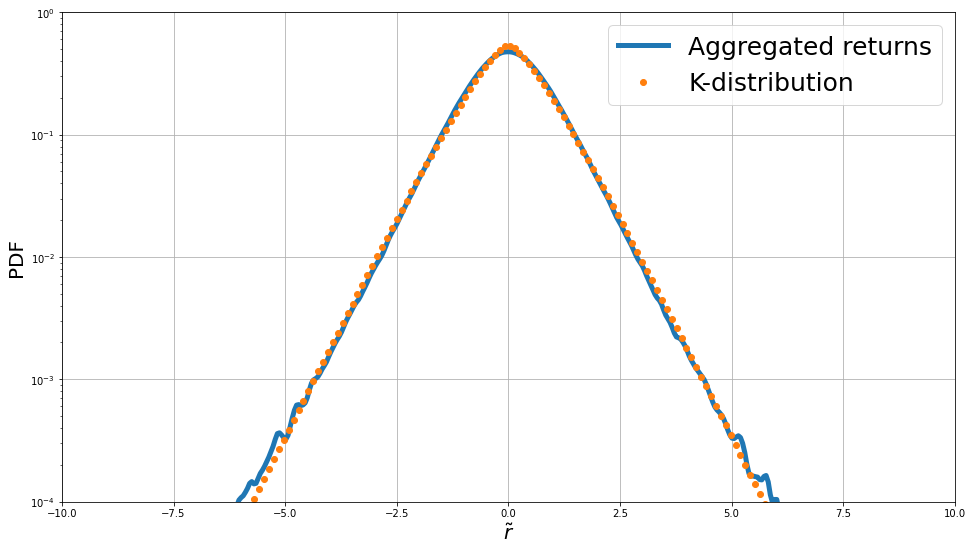

In [12]:
agg.plot(kind='density', figsize=(16, 9), logy=True, label='Aggregated returns', legend=True, lw=5)
plt.plot(rr, bessel, 'o', label='K-distribution')
plt.legend(fontsize=25)
plt.xlim(-10, 10)
plt.ylim(10 ** -4, 1)
plt.xlabel(r'$\tilde{r}$', fontsize=20)
plt.ylabel('PDF', fontsize=20)
plt.grid(True)

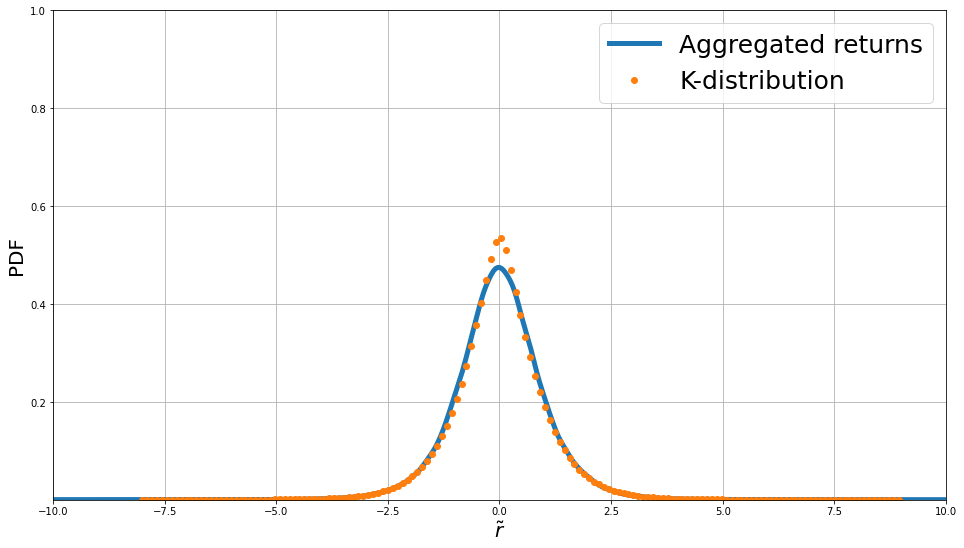

In [13]:
agg[::8].plot(kind='density', figsize=(16, 9), label='Aggregated returns', legend=True, lw=5)
plt.plot(rr, bessel, 'o', label='K-distribution')
plt.legend(fontsize=25)
plt.xlim(-10, 10)
plt.ylim(10 ** -4, 1)
plt.xlabel(r'$\tilde{r}$', fontsize=20)
plt.ylabel('PDF', fontsize=20)
plt.grid(True)

In [14]:
@interact(i=(1, 20, 0.1))
def interactive_k_distribution(i):

    
    agg[::8].plot(kind='density', figsize=(16, 9), label='Aggregated returns', legend=True, lw=5)
    plt.plot(rr, k_distribution(rr, i, 1), 'o', label='K-distribution')
    plt.legend(fontsize=25)
    plt.xlim(-10, 10)
    plt.ylim(10 ** -4, 1)
    plt.xlabel(r'$\tilde{r}$', fontsize=20)
    plt.ylabel('PDF', fontsize=20)
    plt.grid(True)
    
    return None

interactive(children=(FloatSlider(value=10.0, description='i', max=20.0, min=1.0), Output()), _dom_classes=('w…

### Check operations in rotate_and_scale function

In [15]:
cov = daily_returns_T.cov()
cov.shape

(352, 352)

In [16]:
eig_val, eig_vec = np.linalg.eig(cov)
print(eig_val.shape)
print(eig_vec.shape)

(352,)
(352, 352)


In [17]:
rot, scale = eig_vec, np.diag(1 / np.sqrt(eig_val))
print(rot.shape)
print(scale.shape)

(352, 352)
(352, 352)


In [18]:
trans = rot.dot(scale)
trans.shape

(352, 352)

In [19]:
daily_returns_T.dot(trans)

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,-0.139463,0.131148,-0.065896,-0.557259,0.648759,-0.446396,-0.280311,0.139332,-0.311343,0.341929,...,0.853032,-1.812847,-0.034601,-0.467647,-0.787966,-0.177777,-0.672477,-0.443662,-0.357986,-0.006818
1,0.130519,-0.523999,-0.533188,0.080207,0.407482,0.924115,-0.887710,-0.409805,0.242005,-0.601377,...,0.383629,-1.441982,1.095213,-0.993805,1.080280,0.582044,-0.369005,-0.445838,0.892698,-1.485970
2,-0.543544,-0.487678,-0.410257,-0.677041,0.674555,-0.084498,-1.005910,1.188505,0.184292,0.350267,...,0.605686,0.823241,0.471988,-0.923678,0.722716,2.137787,0.939114,1.720872,1.390099,-1.699082
3,-0.848844,-0.823597,-0.785047,-0.527748,0.499856,-0.736688,-1.024233,0.328512,-0.480483,0.107309,...,-2.453457,0.592547,0.859337,0.559137,-0.956495,0.428386,-1.024082,0.839887,-0.249619,-0.498748
4,-0.773622,-0.532562,-0.370892,-0.631730,0.065420,0.558156,-0.014533,0.238190,0.733727,0.127941,...,0.359294,0.164945,-0.193519,-0.068468,-1.045079,0.890359,1.056620,-2.155783,0.608755,-0.672512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4846,-0.733750,0.268548,-0.186677,-0.426613,-0.001896,-0.763596,0.342504,-0.246950,0.028635,0.771835,...,-0.511302,-0.005714,0.246534,0.556459,-0.161353,0.269548,-0.296618,-0.024415,0.034319,-0.579178
4847,-1.004472,-0.331634,0.010390,-0.182976,-0.513353,-1.355027,-0.295800,-0.329860,-0.179492,0.402003,...,-0.412523,0.028564,-0.424798,0.310853,0.572572,0.215272,0.352738,0.280742,-0.119729,1.032836
4848,0.046199,-0.203211,0.250810,0.093851,-0.020565,-0.686791,-0.326363,-0.092363,-0.175445,-0.110445,...,0.435473,-0.435033,-0.284960,0.193208,-0.271351,0.249347,-1.105694,0.856111,1.078176,0.089472
4849,1.735657,-0.277010,0.037569,0.721303,-0.838704,0.067599,0.547490,0.106718,0.393050,-0.286764,...,0.709359,0.554057,0.624871,0.801591,0.661098,-0.561847,-0.025861,-0.128623,-0.240721,-0.249865
